In [1]:
# copy template to $(jupyter --data-dir)/nbextensions/snippets/snippets.json
from logging import basicConfig
from pathlib import Path
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns

from IPython.core.display import HTML
from IPython.display import display, clear_output

warnings.filterwarnings('ignore')

display(
    HTML("""
          <style type="text/css">
          table.dataframe td, table.dataframe th {
              border: 1px  black solid !important;
              color: black !important;
          }
          </style>
         <style>.container { width:100% !important; }</style>
         """))

plt.rcParams['figure.figsize'] = (15, 7)
plt.style.use('ggplot')
mpl.rcParams['figure.dpi'] = 100
sns.set()

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = None
pd.options.display.precision = 2

np.set_printoptions(precision=3, linewidth=200, suppress=True)

basicConfig(level='INFO',
            format='%(asctime)s %(levelname)s %(message)s',
            datefmt='%d/%m/%Y %H:%M:%S%z')
LOGGER = getLogger(__name__)

CACHE = {}

###  MicroGrad demo

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [4]:
np.random.seed(1337)
random.seed(1337)

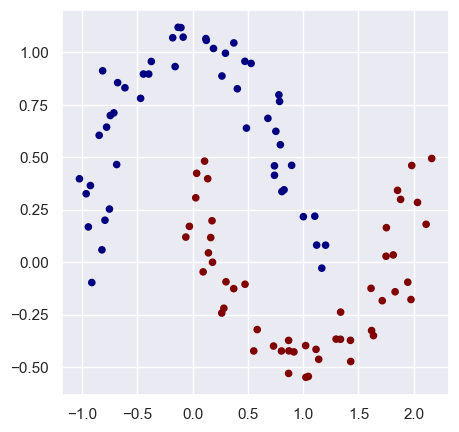

In [5]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs

X, y = make_moons(n_samples=100, noise=0.1)

y = y * 2 - 1  # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='jet')

In [6]:
# initialize a model
model = MLP(2, [8, 8, 1])  # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8)], Layer of [LinearNeuron(8)]]
number of parameters 105


In [7]:
# loss function
def loss(batch_size=None):

    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    
    inputs = Xb

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi * scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p * p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0)
                for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)


total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.7456690791160169, grad=0) 0.69


In [8]:
# optimization
for k in range(100):
    # forward
    total_loss, acc = loss()

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    learning_rate = 1.0 - 0.9 * k / 100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if k % 1 == 0:
        print(f"step {k} loss {round(total_loss.data, pd.options.display.precision)}, accuracy {acc * 100}%")

step 0 loss 0.75, accuracy 69.0%
step 1 loss 1.01, accuracy 50.0%
step 2 loss 0.81, accuracy 81.0%
step 3 loss 0.41, accuracy 80.0%
step 4 loss 0.38, accuracy 81.0%
step 5 loss 0.37, accuracy 81.0%
step 6 loss 0.36, accuracy 83.0%
step 7 loss 0.35, accuracy 82.0%
step 8 loss 0.35, accuracy 83.0%
step 9 loss 0.35, accuracy 82.0%
step 10 loss 0.34, accuracy 85.0%
step 11 loss 0.33, accuracy 84.0%
step 12 loss 0.32, accuracy 85.0%
step 13 loss 0.32, accuracy 86.0%
step 14 loss 0.31, accuracy 87.0%
step 15 loss 0.3, accuracy 86.0%
step 16 loss 0.28, accuracy 87.0%
step 17 loss 0.28, accuracy 88.0%
step 18 loss 0.28, accuracy 87.0%
step 19 loss 0.27, accuracy 88.0%
step 20 loss 0.27, accuracy 88.0%
step 21 loss 0.26, accuracy 89.0%
step 22 loss 0.27, accuracy 88.0%
step 23 loss 0.27, accuracy 89.0%
step 24 loss 0.25, accuracy 89.0%
step 25 loss 0.25, accuracy 91.0%
step 26 loss 0.25, accuracy 89.0%
step 27 loss 0.25, accuracy 91.0%
step 28 loss 0.25, accuracy 89.0%
step 29 loss 0.24, accura

(-1.548639298268643, 1.951360701731357)

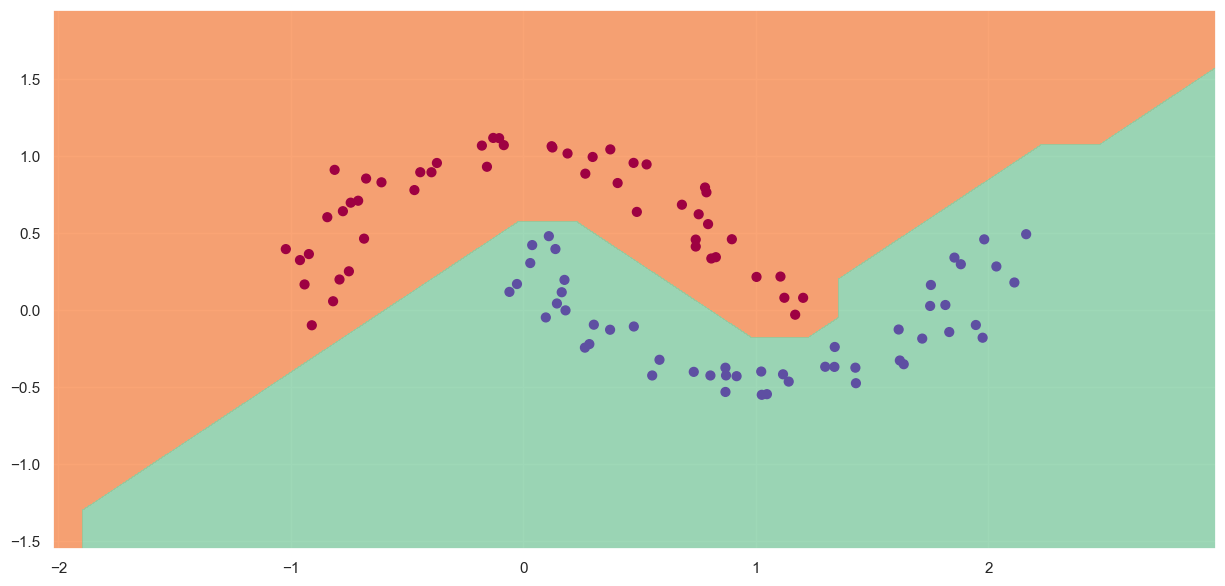

In [11]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]

scores = list(map(model, inputs))

Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())